# Chatbot with HITL (Human in the Loop)

Agent 처리도중 사람의 개입이 필요한 경우 iterrupt처리할 수 있다.
- 사람의 개입(tool)
- 사람 메세지(command)로 대화를 재개할 수 있다.

In [18]:
!pip install langchain langgraph langchain-openai langchain-community langchain-tavily -Uq

In [19]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = os.getenv('langsmith_key')
os.environ['LANGSMITH_PROJECT'] = 'skn23-langchain'
os.environ['OPENAI_API_KEY'] = os.getenv("openai_key")
os.environ['TAVILY_API_KEY'] = os.getenv("tavily_key")

## 도구 정의

In [20]:
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=3)
tavily_tool.invoke('랭그래프에서 노드란 무엇인가요?')

{'query': '랭그래프에서 노드란 무엇인가요?',
 'response_time': 0.7,
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://wikidocs.net/261580',
   'title': '1-3-3. 노드 (Node) - LangGraph 가이드북',
   'content': 'LangGraph에서 노드(Node)는 실제 작업을 수행하는 핵심 단위입니다. 각 노드는 Python 함수로 구현되며, 현재 상태를 입력받아 처리하고 업데이트된 상태를 반환',
   'score': 0.99890125,
   'raw_content': None},
  {'url': 'https://x2bee.tistory.com/430',
   'title': '[LangGrpah] 2. LangGrpah(랭그래프)의 핵심 요소의 개념적 이해',
   'content': 'LangGrpah(랭그래프)를 이용한 AI Workflow 관리하기](https://x2bee.tistory.com/429). LangGraph를 이용한 RAG 및 검색 Agent 개발](https://x2bee.tistory.com/433). LangGraph는 기본적으로 **다양한 도구(정확하게는 Node)들의 연결된 집합으로 이해**할 수 있다. from typing_extensions import TypedDict # State class ExampleState(TypedDict): number: int # Node def make_squered_node(state: ExampleState): return {number: (state[\'number\'])**2}. 3. 이러한 변수 혹은 노드 내부에서 정의된 기능을 수행한 뒤, **[다음 노드가 요구하는 형태]의 State를 반환**한다. messages의 관리 from typing import Annotated from ty

## 사람개입 도구

In [21]:
from langchain_core.tools import tool  # Tool 데코레이터
from langgraph.types import interrupt  # 사람 응답을 기다리는 interrupt

@tool
def human_assist(query):
    """사람의 개입이 필요하면 이 도구를 사용하세요."""
    # interrupt: graph 수행을 사람의 응답(commna)가 도착할때까지 대기
    human_response = interrupt({'query': query})
    return human_response['data']  # 사람이 준 응답데이터만 반환

## 그래프 구성

In [22]:
from typing import TypedDict, List, Annotated
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model

class State(TypedDict):
    messages: Annotated[List, add_messages]

llm = init_chat_model('gpt-4.1-mini')
tools = [tavily_tool, human_assist]
llm_with_tools = llm.bind_tools(tools)  # LLM에 tools call이 필요한 경우 호출 바인딩

def chatbot(state: State):
    response = llm_with_tools.invoke(state['messages'])  # 누적된 메시지로 LLM 호출 (필요시 tool 호출)
    return {'messages': [response]}

In [23]:
# 인메모리 객체
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

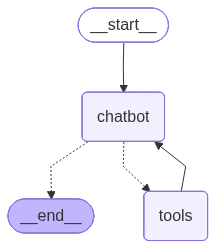

In [24]:
# graph 생성
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END

tool_node = ToolNode(tools)

workflow = StateGraph(State)

workflow.add_node('chatbot', chatbot)
workflow.add_node('tools', tool_node)

workflow.add_edge(START, 'chatbot')
workflow.add_conditional_edges('chatbot', tools_condition)
workflow.add_edge('tools', 'chatbot')

graph = workflow.compile(checkpointer=memory)
graph

## 챗봇 실행

In [25]:
# snapshot함수
from pprint import pprint

# 스냅샷 출력 함수: 저장된 상태(messages)와 다음 실행 노드(next)를 확인
def print_snapshot(graph, config):
    snapshot = graph.get_state(config)  # 해당 config(thread_id)의 상태 스냅샷 조회

    print('Messages: ')
    if 'messages' in snapshot.values:  # 해당 스냅샷에 messages 존재 여부 확인
        pprint(snapshot.values['messages'])  # 누적된 messages 출력
    else:
        print('No messages...')

    # 다음 실행 노드 확인
    print(f'Next: {snapshot.next}') # 다음노드가 있으면 확인가능, () END를 의미(graph 종료)

print_snapshot(graph, {'configurable': {'thread_id': 'user1'}})

Messages: 
No messages...
Next: ()


In [26]:
# 사람개입이 필요없는 대화시작
user1_config = {'configurable': {'thread_id': 'user1'}}
state = {'messages': [('human', '멀티에이젼트 개발을 위한 langgraph의 특징이 무엇인가요?')]}
response = graph.invoke(state, user1_config)
print(response['messages'][-1].content)

langgraph는 멀티에이전트 시스템 개발에 사용되는 프레임워크로, 특히 LangGraph Supervisor 아키텍처 기반의 AI 멀티 에이전트 시스템에 적용됩니다. 이를 통해 여러 전문 에이전트와 다양한 데이터 소스를 활용하여 복잡한 문제를 분석하고 해결할 수 있는 시스템을 구현할 수 있습니다.

주요 특징은 다음과 같습니다:
1. 멀티 에이전트 콜라보레이션 지원: 여러 에이전트가 협력하여 작업을 수행할 수 있는 구조를 제공합니다.
2. 다양한 데이터 소스 통합: 여러 데이터 소스를 연결하여 보다 풍부한 정보를 활용할 수 있습니다.
3. 전문 에이전트 구성 가능: 각기 다른 분야의 전문 에이전트를 구성하여 역할 분담이 가능합니다.
4. 워크플로우 및 협업 관리: 에이전트 간의 효율적인 협업과 작업 흐름 관리 기능을 갖추고 있습니다.

이와 같은 특징으로 langgraph는 멀티에이전트 시스템의 개발과 운영을 용이하게 하는 플랫폼으로 활용됩니다.


In [27]:
print_snapshot(graph, user1_config)

Messages: 
[HumanMessage(content='멀티에이젼트 개발을 위한 langgraph의 특징이 무엇인가요?', additional_kwargs={}, response_metadata={}, id='3b821604-834a-4d93-a13e-bbde1ca74dab'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 1235, 'total_tokens': 1273, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_75546bd1a7', 'id': 'chatcmpl-D7YfQT5yLhJwAeBUcK9R8NcTcUfnz', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c4595-2391-7673-a87f-7e91d200e5c1-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'langgraph 특징 멀티에이젼트 개발', 'include_domains': ['github.com', 'langgraph.dev']}, 'id': 'call_Wz2U2XvZzRoD6IDeYS0V0XwA', 'type': '

In [28]:
# 사람개입이 필요한 대화 시작
from langchain_core.prompts import ChatPromptTemplate

system_prompt = """
**Instruction**
사용자는 케이크 주문, 메뉴 문의, 매장 정보 등을 챗봇에 요청할 수 있다.
챗봇은 친절하고 정확하게 답변한다.

**Context**
당신은 프리미엄 케이크샵의 공식 챗봇이다.
- 운영 시간: 매일 09:00–21:00
- 주요 메뉴: 생크림 케이크, 초코 케이크, 치즈 케이크, 시즌 한정 케이크
- 매장 위치: 서울 강남구 신사동 123-45
- 연락처: 02-1234-5678

**Example**
> **User:** “다음 주 수요일 오후 3시에 케이크 예약 가능한가요?”
> **Bot:** “안녕하세요! 다음 주 수요일(2025년 7월 16일) 오후 3시에 예약 가능합니다. 예약을 원하시면 성함과 연락처를 알려주세요.”

**Output Indicator**
- 챗봇 응답은 한 문단 이내로 간결하게 제시한다.
- 필요한 경우 날짜·시간은 YYYY년 M월 D일 형식으로 명시한다.
- 추가 질문이 필요할 때에는 “추가로 궁금하신 점이 있으면 말씀해주세요.” 로 마무리한다.
- 그외 답변하기 어려운 경우, human_assist 도구를 사용하여 인간의 도움을 요청한다.
"""
user_prompt = '당근케익 4호가 홈페이지에서 구매가 안되는데, 매니져님께 구매가능여부를 묻고 싶어요.'
prompt = ChatPromptTemplate.from_messages([
    ('system', system_prompt),
    ('human', '{user_prompt}')
])

state = {'messages': prompt.format_messages(user_prompt=user_prompt)}  # 템플릿에 값 주입해 누적 messages 생성
response = graph.invoke(state, user1_config)  # 그래프 실행 (필요시 tools/human_assistant로 분기)
print(response['messages'][-1].content)

안녕하세요! 당근케익 4호는 현재 홈페이지에서 구매가 어려운 상태일 수 있습니다. 제가 매니저님께 구매 가능 여부를 확인해 드리겠습니다. 잠시만 기다려 주세요. 추가로 궁금하신 점이 있으면 말씀해주세요.


In [29]:
# 스냅샷확인
print_snapshot(graph, user1_config)

Messages: 
[HumanMessage(content='멀티에이젼트 개발을 위한 langgraph의 특징이 무엇인가요?', additional_kwargs={}, response_metadata={}, id='3b821604-834a-4d93-a13e-bbde1ca74dab'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 1235, 'total_tokens': 1273, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_75546bd1a7', 'id': 'chatcmpl-D7YfQT5yLhJwAeBUcK9R8NcTcUfnz', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c4595-2391-7673-a87f-7e91d200e5c1-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'langgraph 특징 멀티에이젼트 개발', 'include_domains': ['github.com', 'langgraph.dev']}, 'id': 'call_Wz2U2XvZzRoD6IDeYS0V0XwA', 'type': '

In [30]:
# 사람 개입 코드
from langgraph.types import Command  # interrupt를 재개(resume)하기 위한 Command

human_response = '''
물론입니다. 구매가능하시고요, 홈페이지 구매가능하도록 바로 조치해드릴게요.
가격은 15만원입니다. 감사합니다.
'''
command = Command(resume={'data': human_response})
response = graph.invoke(command, user1_config)
print(response['messages'][-1].content)

당근케익 4호는 구매 가능하며, 현재 홈페이지 구매가 가능하도록 조치 중입니다. 가격은 15만원입니다. 추가로 궁금하신 점이 있으면 말씀해주세요.


In [31]:
print_snapshot(graph, user1_config)

Messages: 
[HumanMessage(content='멀티에이젼트 개발을 위한 langgraph의 특징이 무엇인가요?', additional_kwargs={}, response_metadata={}, id='3b821604-834a-4d93-a13e-bbde1ca74dab'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 1235, 'total_tokens': 1273, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_75546bd1a7', 'id': 'chatcmpl-D7YfQT5yLhJwAeBUcK9R8NcTcUfnz', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c4595-2391-7673-a87f-7e91d200e5c1-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'langgraph 특징 멀티에이젼트 개발', 'include_domains': ['github.com', 'langgraph.dev']}, 'id': 'call_Wz2U2XvZzRoD6IDeYS0V0XwA', 'type': '